In [137]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import decord
import json


In [108]:
# Load video
video_path = r'C:\Users\chataint\Documents\projet\pose_pipeline\segmentation\data\video\bedroom.mp4'
# cap = cv2.VideoCapture(video_path)
vr = decord.VideoReader(video_path)
# Load JSON file
json_path = r'C:\Users\chataint\Documents\projet\pose_pipeline\segmentation\data\video\bedroom_mask.json'
with open(json_path, 'r') as f:
    mask_data = json.load(f)


In [109]:
def rle_to_mask(rle) -> np.ndarray:
    """Compute a binary mask from an uncompressed RLE."""
    h, w = rle["size"]
    mask = np.empty(h * w, dtype=bool)
    idx = 0
    parity = False
    for count in rle["counts"]:
        mask[idx : idx + count] = parity
        idx += count
        parity ^= True
    mask = mask.reshape(w, h)
    return mask.transpose()  # Put in C order


def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [110]:
mask_data.get('frames')

[{'idx': 0,
  'points': [{'0': {'0': {'point': [407, 136], 'label': 1}}},
   {'0': {'0': {'point': [412, 42], 'label': 1}}},
   {'0': {'0': {'point': [396, 214], 'label': 1}}},
   {'0': {'0': {'point': [382, 300], 'label': 1}}}],
  'bboxs': [{'0': {'8': {'bbox': [136, 122, 298, 424]}}}],
  'masks': {'target_ids': [8, 0],
   'rle_masks': [{'size': [540, 960],
     'counts': [78696,
      4,
      534,
      6,
      533,
      8,
      531,
      9,
      530,
      11,
      529,
      11,
      528,
      12,
      528,
      12,
      527,
      14,
      524,
      16,
      524,
      16,
      523,
      17,
      523,
      17,
      523,
      18,
      522,
      18,
      521,
      19,
      520,
      21,
      518,
      22,
      518,
      22,
      517,
      23,
      517,
      23,
      516,
      24,
      515,
      25,
      514,
      27,
      511,
      29,
      509,
      31,
      507,
      33,
      506,
      34,
      448,
      6,
      51,
      35,
   

In [111]:
# check idx ==  index of frame in the list
frames = mask_data.get('frames')
for i, frame in enumerate(frames):
    assert frame['idx'] == i, f"Index mismatch at frame {i}: {frame['idx']} != {i}"

In [112]:
def get_mask(frame_number, mask_data):
    """Retrieve the masks associated with a specific frame."""
    frames = mask_data.get('frames')
    if frame_number < len(frames):
        frame = frames[frame_number]
        points = frame.get('points', {})
        bboxs = frame.get('bboxs', {})
        masks =  frame.get('masks', [])
        return points, bboxs, masks
    return None

In [113]:
# Define colors for each target_id
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]


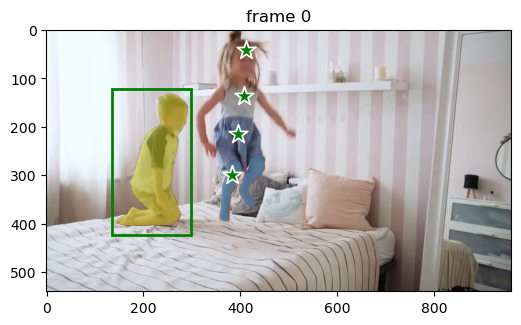

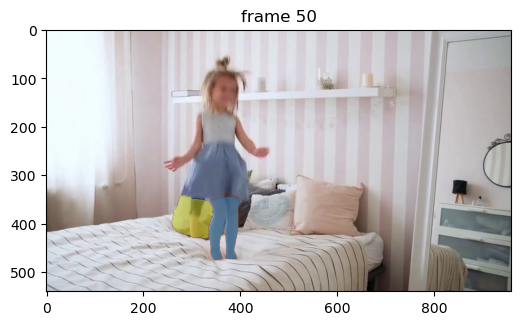

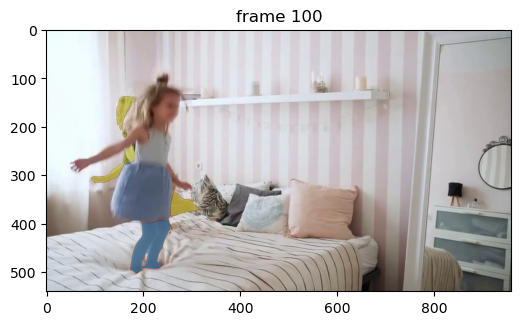

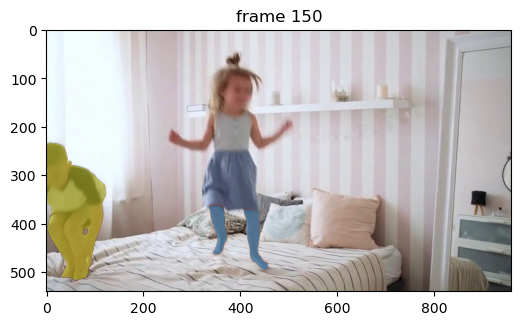

In [129]:
for last_id in range(0,len(vr), 50):
    frame = vr[last_id].asnumpy()
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {last_id}")
    plt.imshow(frame)

    points, bboxs, masks = get_mask(last_id, mask_data)
    if masks:
        for target_id, rle_mask in zip(masks.get('target_ids'), masks.get('rle_masks')):
            mask = rle_to_mask(rle_mask)
            show_mask(mask, ax=plt.gca(), obj_id=target_id)
    if bboxs:
        for un_truc in bboxs:
            un_trutruc = un_truc[str(last_id)]
            for target_id in un_trutruc.keys():
                bbox = un_trutruc[str(target_id)]['bbox']
                show_box(bbox, ax=plt.gca())
    if points:
        for point in points:
            point = point[str(last_id)]
            for target_id in point.keys():
                show_points(np.array([point[target_id]['point']]), np.array([point[target_id]['label']]), ax=plt.gca())
                        # ax.imshow(frame)
        # plt.show()
# frame = vr[last_id]


In [141]:
def mask_to_bbox(mask):
    """Convert a binary mask to a bounding box."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if rows.any():
        y_min, y_max = np.where(rows)[0][[0, -1]]
        x_min, x_max = np.where(cols)[0][[0, -1]]
        return [int(x_min), int(y_min), int(x_max), int(y_max)]
    return [0, 0, 0, 0]

# Dictionary to store bounding boxes with image id as key
bbox_dict = {}

for last_id in range(0, len(vr)):

    points, bboxs, masks = get_mask(last_id, mask_data)
    if masks:
        bbox_dict[str(last_id)] = {}
        for target_id, rle_mask in zip(masks.get('target_ids'), masks.get('rle_masks')):
            mask = rle_to_mask(rle_mask)
            bbox = mask_to_bbox(mask)
            # Save bounding box in dictionary
            bbox_dict[str(last_id)][target_id] = bbox

# Save bbox_dict as a JSON file
output_json_path = r'C:\Users\chataint\Documents\projet\pose_pipeline\segmentation\data\video\bbox_dict.json'
with open(output_json_path, 'w') as outfile:
    json.dump(bbox_dict, outfile)

In [142]:
bbox_dict

{'0': {8: [145, 134, 292, 405], 0: [359, 257, 450, 396]},
 '1': {8: [151, 122, 293, 402], 0: [358, 286, 447, 424]},
 '2': {8: [152, 117, 294, 397], 0: [352, 317, 439, 452]},
 '3': {8: [157, 116, 295, 383], 0: [349, 350, 429, 464]},
 '4': {8: [161, 118, 296, 376], 0: [350, 385, 417, 480]},
 '5': {8: [166, 124, 298, 376], 0: [348, 399, 417, 484]},
 '6': {8: [173, 134, 302, 377], 0: [348, 384, 414, 475]},
 '7': {8: [178, 145, 305, 388], 0: [344, 357, 415, 468]},
 '8': {8: [181, 160, 308, 407], 0: [339, 333, 431, 457]},
 '9': {8: [183, 179, 309, 424], 0: [332, 310, 433, 448]},
 '10': {8: [185, 204, 318, 426], 0: [323, 295, 430, 430]},
 '11': {8: [187, 225, 315, 433], 0: [316, 285, 429, 412]},
 '12': {8: [186, 243, 312, 441], 0: [305, 277, 422, 403]},
 '13': {8: [187, 247, 310, 444], 0: [296, 272, 413, 398]},
 '14': {8: [188, 237, 309, 439], 0: [283, 271, 404, 398]},
 '15': {8: [189, 218, 302, 434], 0: [273, 275, 401, 422]},
 '16': {8: [185, 194, 295, 432], 0: [267, 284, 398, 426]},
 '17': 